Fútbol Match Highlights<br>
Focus vs Unfocused Model - Capstone 2<br>
Tom Widdows

This notebook trains and saves a model that can distinguish between in-focus faces and out-of-focus faces.<br><br>
In the picture below, the face detector located 5 faces.  The player in the foreground is in very sharp focus while the remaining 4 players are out-of-focus. Face recognition should work with the in-focus player but not with the remaining 4 out-of-focus players.
 

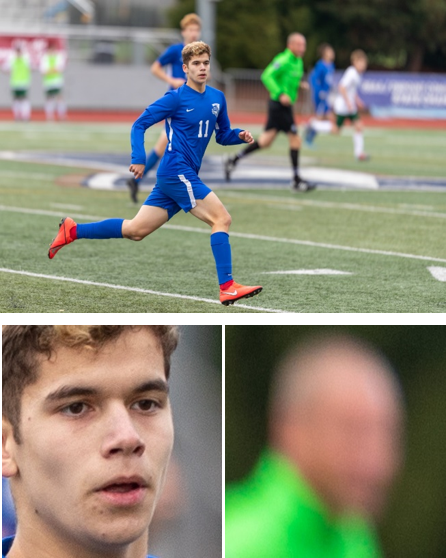

The main application loads this model and verifies that detected faces in the current image are in-focus before attempting facial recognition.  The notebooks purpose is to train and save a model for later use in the main applicaiton. 

##### Housekeeping...

In [1]:
import sys
sys.path.append('../code')
import settings as s

import ast
import csv
from hyperopt import fmin,tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb
from lightgbm import LGBMClassifier
from measures import mcc_eval, mcc, eval_mcc, lgb_f1_score, lgb_kappa_score
import numpy as np 
import pandas as pd 
from pathlib import Path
import pickle
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from support_class import Fball, time_it
import time
from timeit import default_timer as timer

start_all = time.time()  # track time for notebook to run
%matplotlib inline

Using TensorFlow backend.


##### Common variables and settings...

In [2]:
# common variables used throughout the notebook
random.seed(14)

# save figure unique filenames
cm_valid_fig = Fball.checkfile('08 - 01 Extended Focused vs Unfocused Model CM Valid.jpg', ir=False)
cm_test_fig = Fball.checkfile('08 - 01 Extended Focused vs Unfocused Model CM Test.jpg', ir=False)

#Hyperopt variables
hyperopt_trials = s.MODELS / 'focused_vs_unfocused_hyperopt_trials.csv'
MAX_EVALS  = 50
N_FOLDS = 3

# classifiers
classification_algos_name = [
    "KNeighborsClassifier",
    "GaussianNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "LGBMClassifier"
]

classification_algos = [
    KNeighborsClassifier(20),
    GaussianNB(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LGBMClassifier()
]

#### Get and Load our two datasets

In [3]:
in_focus_faces = [f for f in Path(s.FOCUSED_VS_UNFOCUSED_DATASET / 'extended_in_focus_faces').iterdir()]
out_of_focus_faces = [f for f in Path(s.FOCUSED_VS_UNFOCUSED_DATASET / 'extended_out_of_focus_faces').iterdir()]
Fball.count_summary([in_focus_faces, out_of_focus_faces], ['images in-focus', 'images out-of-focus faces', 'total images'])

  655 images in-focus
1,701 images out-of-focus faces
2,356 total images


In [4]:
# feature engineering for sharp images
@time_it
def get_in_focus_faces_df():
    return Fball.get_data(in_focus_faces) # multiprocessing for speed
df_in_focus = get_in_focus_faces_df()

00:00:15


In [5]:
# feature engineering for defocused images
@time_it
def get_out_of_focus_faces_df():
    return Fball.get_data(out_of_focus_faces) # multiprocessing for speed
df_out_of_focus = get_out_of_focus_faces_df()

00:00:16


#### Combine the data

In [6]:
df = pd.DataFrame()
df = df.append(df_in_focus)
df = df.append(df_out_of_focus)
feature_names = ['laplace-mean','laplace-var','laplace-max',
                 'sobel-mean','sobel-var','sobel-max',
                 'roberts-mean','roberts-var','roberts-max',
                 'canny-mean','canny-var','canny-max']
df.columns = feature_names

##### Scale and split data

In [7]:
# prepare and split the data
X = df
y = np.concatenate((np.ones(df_in_focus.shape[0]), np.zeros(df_out_of_focus.shape[0])), axis=0)

scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = feature_names

X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_and_valid, y_train_and_valid, train_set = Fball.train_valid_test(X, y, hyperopt_train_set=True)


Total Data:                   2,356  100%  X

Test (holdout) data:            236   10%  X_test
Train and Validation data:    2,120   90%  X_train_and_valid

Train data:                   1,696   72%  X_train
Validation data:                424   18%  X_valid


Note: Created train_set for Hyperopt


#### Run classifiers, compare performance and choose best classifier

In [8]:
# run the classifiers

start = time.time()
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []
models = []

print(f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}')

for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec")

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             93.63%    88.51%     88.89%    88.14%    91.94%  0.04 sec
GaussianNB                       91.75%    85.23%     84.87%    85.59%    89.86%  0.00 sec
DecisionTreeClassifier           94.58%    90.38%     89.26%    91.53%    93.64%  0.01 sec
ExtraTreeClassifier              92.45%    86.78%     84.68%    88.98%    91.39%  0.00 sec
LGBMClassifier                   95.28%    91.53%     91.53%    91.53%    94.13%  0.20 sec


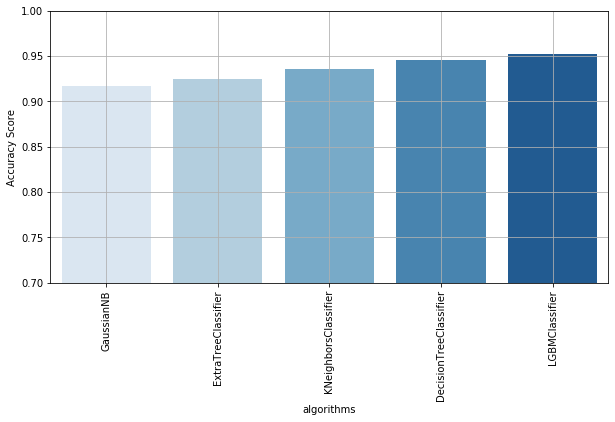

Best classifier: LGBMClassifier

Selecting LGBMClassifier
   LGBMClassifier has features_importances_
   LGBMClassifier does NOT has coef_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)



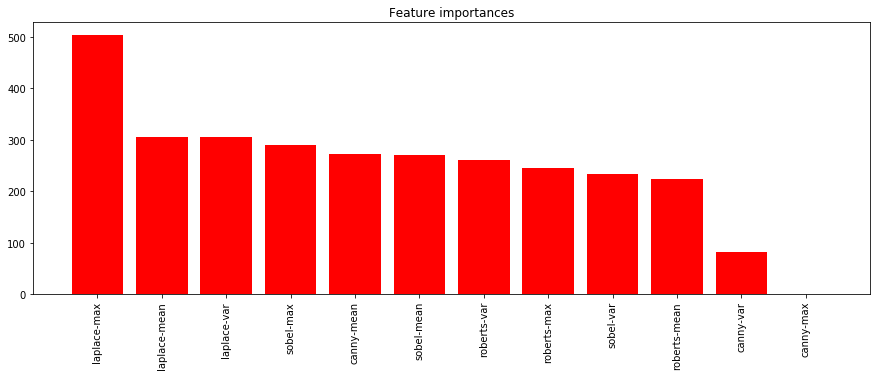

In [9]:
# compare the classifiers and look at best 
model_best_roc = Fball.plot_model_comparison(classification_algos_name, accuracy_score_list, [.7,1])
model = Fball.get_model_info(classification_algos, model_best_roc, classification_algos_name, X_train, y_train)

##### Train the best classifier on the train data and predict on the validation data

The baseline score (roc_auc) on the validation set is 98.60%



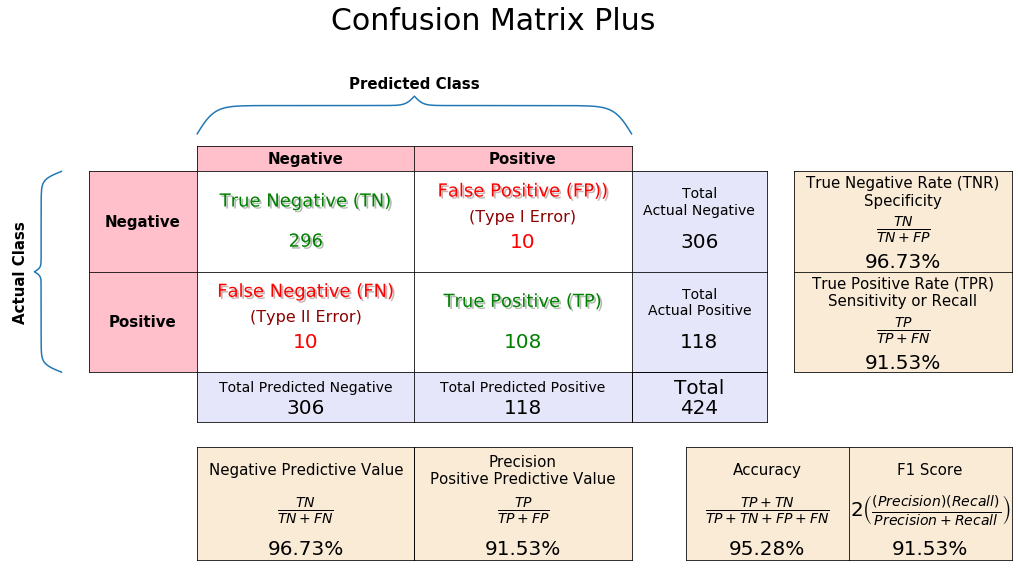


The kappa score is 88.26%

The MCC score is 88.26%

00:00:01


In [10]:
y_pred_prob = Fball.eval_model_valid(model, X_train, y_train, X_valid, y_valid, print_kappa=True, print_mcc=True)

##### Review the Confusion Matrix at cutoffs from 1 to 100

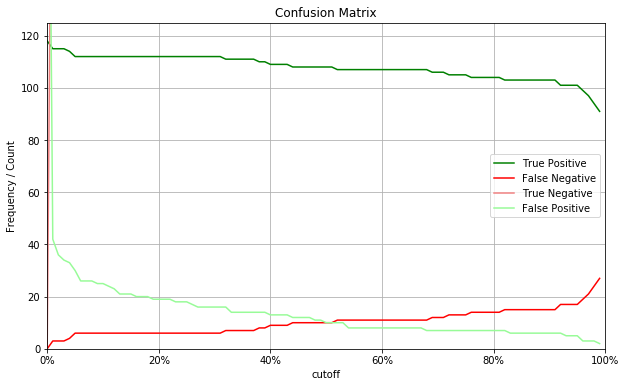

In [11]:
df_cutoff = Fball.graph_cutoff(y_pred_prob, y_valid)

##### Choose a cutoff based on the above plot and reevaluate on plots and confusion matrix below

In [12]:
_cutoff = 30

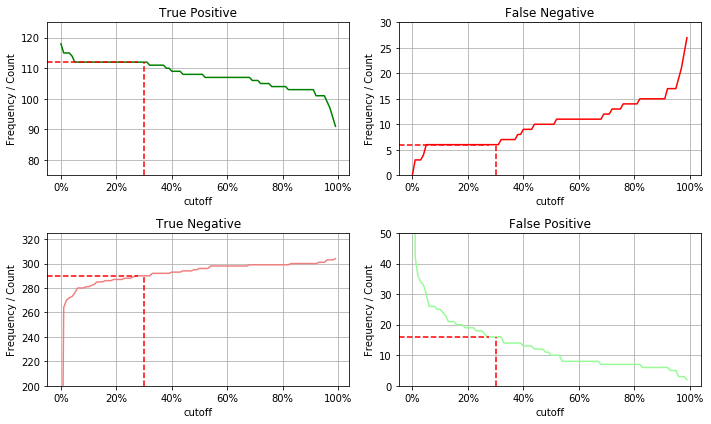

In [13]:
y_limits = [(75, 125), (0, 30), (200, 325), (0, 50)]
Fball.exploded_cm(df_cutoff, _cutoff, y_limits)

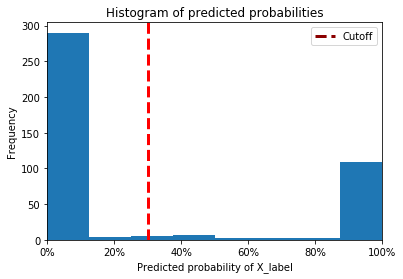

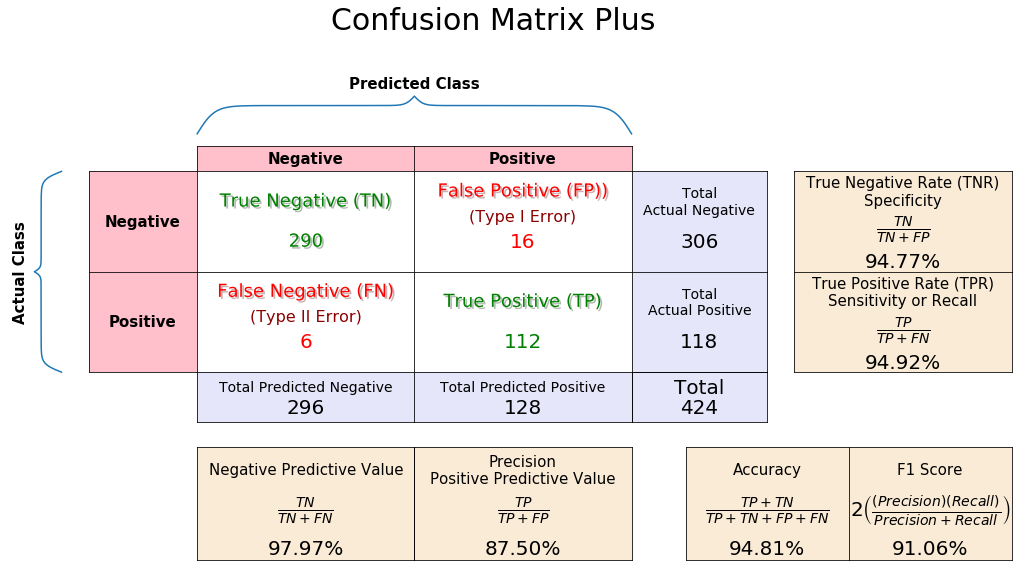

The kappa score is 88.26%
The MCC score is 88.26%



In [14]:
cutoff = Fball.cm_after_cutoff(_cutoff, y_pred_prob, X_valid, y_valid, print_kappa=True, print_mcc=True)

#### Tune Model

In [15]:
# N_FOLDS  ***set in common variables

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
  
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 500, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', feval=mcc_eval)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['MCC-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['MCC-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [16]:
# Define the search space
space = {'num_leaves': hp.quniform('num_leaves', 30, 500, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

In [17]:
# hyperopt params
bayes_trials = Trials()  # Keep track of results

# File to save first results
out_file = hyperopt_trials
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [18]:
# MAX_EVALS ***set in common variables
global  ITERATION
ITERATION = 0
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50),
           show_progressbar=True)

100%|███████████████████████████████████████████████| 50/50 [01:04<00:00,  1.28s/trial, best loss: 0.10399685606741016]


In [19]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1] # uncomment/comment to show/hide best trial

[{'loss': 0.10399685606741016,
  'params': {'learning_rate': 0.08859491611609897, 'num_leaves': 159},
  'iteration': 8,
  'estimators': 23,
  'train_time': 0.9851951999999997,
  'status': 'ok'}]

In [20]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
# results.head()  # uncomment to view results

In [21]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train and validation data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objelctive = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08859491611609897,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=23, n_jobs=-1, num_leaves=159,
               objective=None, objelctive='binary', random_state=50,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


The best model from Bayes optimization scores 98.63% AUC ROC on the validation set.
This was achieved after 8 search iterations



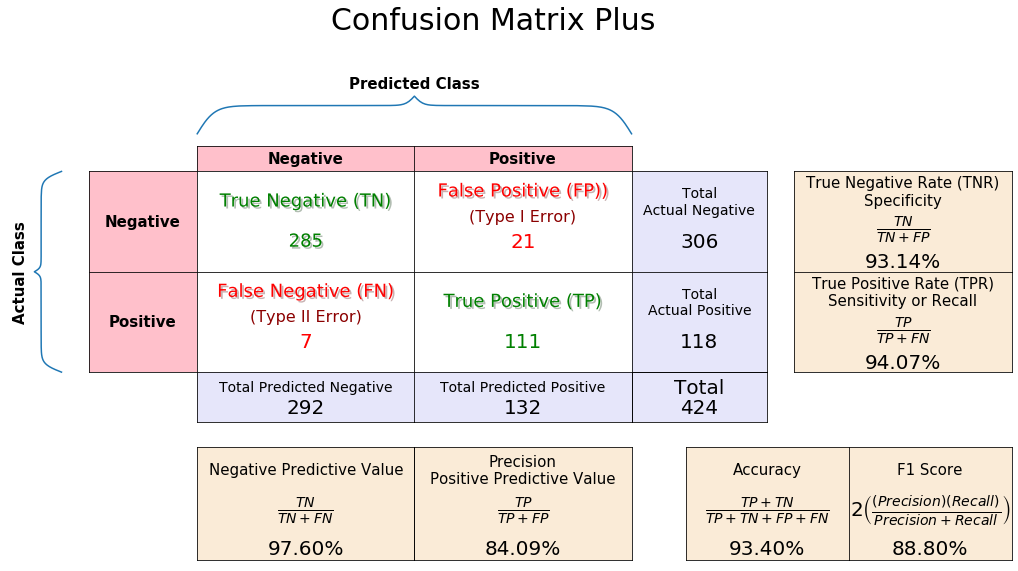


The kappa score is 84.14%

The MCC score is 84.40%



In [22]:
Fball.eval_hyperopt_on_valid(best_bayes_model, X_valid, y_valid, results, cutoff, print_kappa=True, print_mcc=True, save_fig=cm_valid_fig)

##### Retrain model on train & validation data and predict on test (holdout) data using hyperopt paramaters

In [23]:
# retrain model with best paramaters using train and validation data
best_bayes_model.fit(X_train_and_valid, y_train_and_valid)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.08859491611609897,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=23, n_jobs=-1, num_leaves=159,
               objective=None, objelctive='binary', random_state=50,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


The best model from Bayes optimization scores 98.45% AUC ROC on the test set.
This was achieved after 8 search iterations



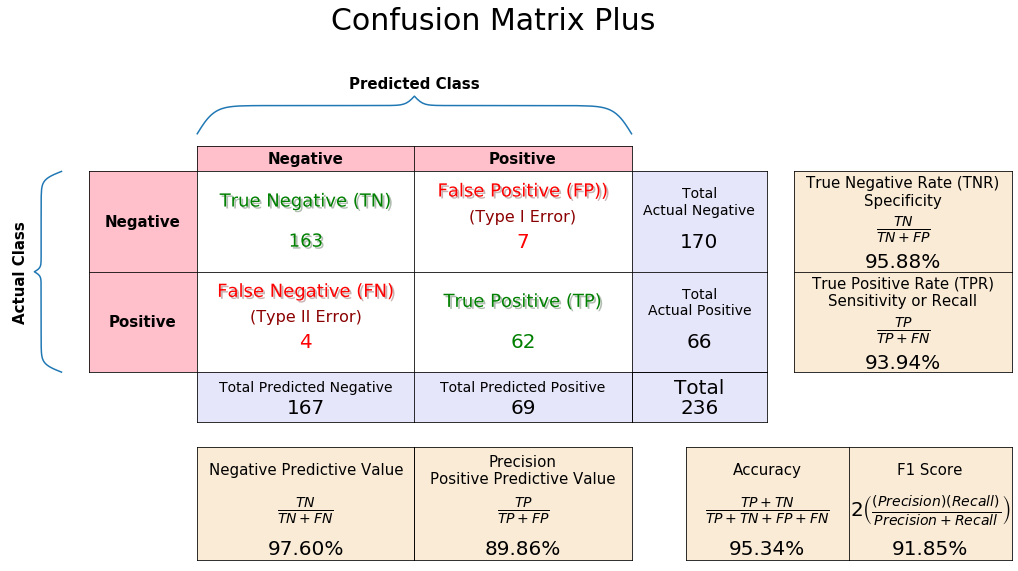


The kappa score is 88.59%

The MCC score is 88.63%



In [24]:
Fball.eval_hyperopt_on_test(best_bayes_model, X_test, y_test, results, cutoff, print_kappa=True, print_mcc=True, save_fig=cm_test_fig)

#### Save the model

In [25]:
Fball.save_model(best_bayes_model, 'extended_focused_vs_unfocused_model', ir=False)
Fball.save_model(scaler, 'extended_focused_vs_unfocused_scaler', ir=False)

In [26]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}   ({MAX_EVALS:,.0f} Hyperopt evals)')

00:01:43   (50 Hyperopt evals)
